In [1]:
import numpy as np
import os   # 운영체제와 상호작용하기 위한 모듈
from dotenv import load_dotenv

load_dotenv()
base_dir = os.getenv('BASE_DIR')

# GPU 선택 -> '0': 첫 번째
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# GPU 메모리의 동적 할당 허용
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
folder_name = "landmarks_angle"

data = np.concatenate([
    np.load(os.path.join(base_dir, f'seq_data/{folder_name}/seq_npy_1722471692.npy')),
    np.load(os.path.join(base_dir, f'seq_data/{folder_name}/seq_npy_flip_1722471723.npy')),
    np.load(os.path.join(base_dir, f'seq_data/{folder_name}/seq_npy_flip_shift_1722471774.npy')),
    np.load(os.path.join(base_dir, f'seq_data/{folder_name}/seq_npy_shift_1722471749.npy'))
], axis=0)

print(data.shape)
# (데이터의 개수, 프레임 사이즈, 한 프레임당 데이터 개수)

(7560, 30, 235)


In [3]:
# 시퀀스의 마지막 요소 제외한 모든 값 가져와 할당
# 마지막 요소는 라벨 값
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(data.shape)
print(labels.shape)
print(np.unique(labels))  # 레이블 값 출력

(7560, 30, 235)
(7560,)
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


In [4]:
from setting import actions
from tensorflow import keras
from keras.utils import to_categorical

# 원-핫 인코딩으로 변환
y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape
# y_data 형태 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...]

(7560, 10)

In [5]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)  # 입력 데이터
y_data = y_data.astype(np.float32)  # 레이블

# train data : validation data = 8 : 2
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=2024)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

print(x_train.shape[1:3])

(6048, 30, 234) (6048, 10)
(1512, 30, 234) (1512, 10)
(30, 234)


In [6]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization

model = Sequential([
    LSTM(512, activation='relu', input_shape=x_train.shape[1:3]),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(len(actions), activation='softmax'),
])


# compile(최적화 알고리즘, 레이블 클래스 2개 이상일 때 사용하는 손실 함수, 모델평가지표)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1529856   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 1663754 (6.35 MB)
Trainable params: 1663754 (6.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# 모델 훈련
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=128,
    callbacks=[
        # save_best_only -> 모델 정확도가 이전보다 향상된 경우에만 모델 저장
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=False, mode='auto'),
        # 정확도 개선이 없을시 학습률(factor) 0.5배로 감소, n 에포크 동안 개선 없을 경우 학습률 감소
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=20, verbose=1, mode='auto'),
        # early stopping 적용
        # EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ]
)

Epoch 1/100


48/48 [==============================] - ETA: 0s - loss: 1.4442 - acc: 0.4709
Epoch 1: saving model to models\model.h5
48/48 [==============================] - 17s 322ms/step - loss: 1.4442 - acc: 0.4709 - val_loss: 1.1921 - val_acc: 0.5681 - lr: 0.0010
Epoch 2/100


c:\Users\mshof\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/48 [==============================] - ETA: 0s - loss: 1.1682 - acc: 0.6032
Epoch 2: saving model to models\model.h5
48/48 [==============================] - 18s 380ms/step - loss: 1.1682 - acc: 0.6032 - val_loss: 0.7124 - val_acc: 0.7156 - lr: 0.0010
Epoch 3/100
48/48 [==============================] - ETA: 0s - loss: 0.6497 - acc: 0.7822
Epoch 3: saving model to models\model.h5
48/48 [==============================] - 15s 321ms/step - loss: 0.6497 - acc: 0.7822 - val_loss: 0.5936 - val_acc: 0.7864 - lr: 0.0010
Epoch 4/100
48/48 [==============================] - ETA: 0s - loss: 0.4968 - acc: 0.8312
Epoch 4: saving model to models\model.h5
48/48 [==============================] - 16s 331ms/step - loss: 0.4968 - acc: 0.8312 - val_loss: 0.4108 - val_acc: 0.8598 - lr: 0.0010
Epoch 5/100
48/48 [==============================] - ETA: 0s - loss: 0.2935 - acc: 0.9026
Epoch 5: saving model to models\model.h5
48/48 [==============================] - 16s 336ms/step - loss: 0.2935 - acc: 0.902

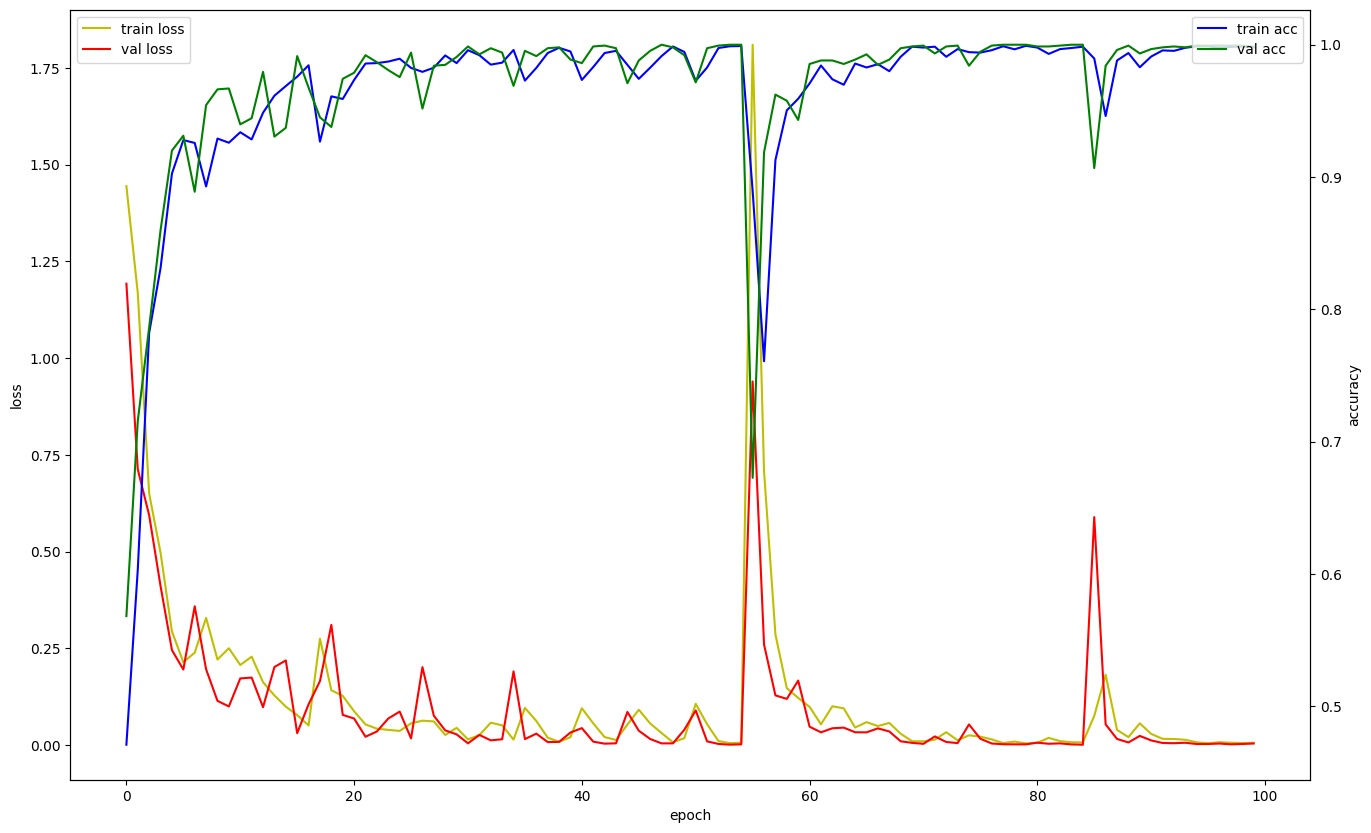

In [8]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right')

plt.show()